# Exploratory Data Analysis: BBCA.JK Stock

## Overview
This notebook performs comprehensive exploratory data analysis (EDA) on BBCA.JK (Bank Central Asia) stock data from August 2022 to July 2025. 

### Objectives:
1. **Data Understanding**: Explore the structure and characteristics of the stock data
2. **Data Quality Assessment**: Identify and handle missing values, outliers, and anomalies
3. **Feature Engineering**: Create meaningful features for time series forecasting
4. **Data Cleaning**: Prepare clean dataset for modeling
5. **Data Preprocessing**: Transform and scale features for machine learning models
6. **Insights Generation**: Extract actionable insights from the data

### Deliverables:
- Clean dataset saved to `../data/clean/`
- Preprocessed dataset saved to `../data/preprocessed/`
- Comprehensive visualizations and statistical analysis

### References:
- https://medium.com/@ttderessa/time-series-forecasting-with-rnn-gru-and-lstm-models-a-comparative-analysis-on-aapl-stock-price-cdcdbd3c5ad8

In [18]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Output directories
os.makedirs('../data/clean', exist_ok=True)
os.makedirs('../data/preprocessed', exist_ok=True)

In [19]:
# Utility print template
print("Title/Section")
print("=" * 75)
print("\nSubtitle/Section")
print("=" * 75)
print(f"   • feature: n")
print(f"      • feature details")

Title/Section

Subtitle/Section
   • feature: n
      • feature details


In [20]:
## 1. Data Loading and Initial Understanding

# Load the raw stock data
# Note: Skipping first 2 rows due to multiline headers in the CSV file
print("Loading BBCA.JK stock data...")

df = pd.read_csv(
    "../data/raw/BBCA.JK_2022-08-01_to_2025-07-31.csv", 
    skiprows=2, 
    parse_dates=["Date"], 
    index_col="Date"
)

# Rename columns
df.columns = ["Close", "High", "Low", "Open", "Volume"]

# Display basic information
print(f"Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Trading days: {len(df)} days")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Loading BBCA.JK stock data...
Data loaded successfully!
Dataset shape: (716, 5)
Date range: 2022-08-01 00:00:00 to 2025-07-30 00:00:00
Trading days: 716 days

First 5 rows of the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2022-08-01,6878.446289,6878.446289,6740.877363,6740.877363,104841600
2022-08-02,6970.158691,6993.086845,6878.446077,6970.158691,106466900
2022-08-03,6993.086426,6993.086426,6947.230121,6993.086426,60170600
2022-08-04,7153.583984,7153.583984,7016.015062,7038.943215,164221000
2022-08-05,7222.368164,7222.368164,7084.799247,7176.511858,118734200


In [21]:
## 2. Data Quality Assessment

# Check for missing values
print("Data Quality Assessment")
print("=" * 75)

print(f"Dataset Info:")
print(f"   • Total observations: {len(df)}")
print(f"   • Features: {list(df.columns)}")
print(f"   • Data types: {df.dtypes.to_dict()}")

print(f"\nDate Index Quality:")
print(f"   • Missing dates in index: {df.index.isnull().sum()}")
print(f"   • Duplicate dates: {df.index.duplicated().sum()}")

print(f"\nMissing Values Analysis:")
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df) * 100).round(2)

for col in df.columns:
    print(f"   • {col}: {missing_counts[col]} ({missing_percentages[col]}%)")

# Check for any weird values (negative prices, zero volume, etc.)
print(f"\nData Anomaly Check:")
print(f"   • Negative prices: {(df[['Open', 'High', 'Low', 'Close']] < 0).sum().sum()}")
print(f"   • Zero volume days: {(df['Volume'] == 0).sum()}")
print(f"   • High > Low check: {(df['High'] < df['Low']).sum()} violations")
print(f"   • Open/Close within High/Low: {((df['Open'] > df['High']) | (df['Open'] < df['Low']) | (df['Close'] > df['High']) | (df['Close'] < df['Low'])).sum()} violations")

# Data summary statistics
print(f"\nData Summary Statistics:")
df.describe()

Data Quality Assessment
Dataset Info:
   • Total observations: 716
   • Features: ['Close', 'High', 'Low', 'Open', 'Volume']
   • Data types: {'Close': dtype('float64'), 'High': dtype('float64'), 'Low': dtype('float64'), 'Open': dtype('float64'), 'Volume': dtype('int64')}

Date Index Quality:
   • Missing dates in index: 0
   • Duplicate dates: 0

Missing Values Analysis:
   • Close: 0 (0.0%)
   • High: 0 (0.0%)
   • Low: 0 (0.0%)
   • Open: 0 (0.0%)
   • Volume: 0 (0.0%)

Data Anomaly Check:
   • Negative prices: 0
   • Zero volume days: 0
   • High > Low check: 0 violations
   • Open/Close within High/Low: 1 violations

Data Summary Statistics:


,Close,High,Low,Open,Volume
count,716.000000,716.000000,716.000000,716.000000,7.160000e+02
mean,8750.874553,8825.049316,8680.017828,8749.615661,8.816058e+07
std,764.373252,769.975506,761.169817,771.202818,6.418403e+07
min,6878.446289,6878.446289,6740.877363,6740.877363,1.065390e+07
25%,8217.211914,8278.755801,8170.256400,8215.218438,5.565425e+07
50%,8625.000000,8686.767445,8562.326521,8639.810651,7.675060e+07
75%,9343.750000,9435.907170,9264.925745,9346.645851,9.953125e+07
max,10570.414062,10570.414062,10401.480469,10522.147296,7.564316e+08


In [22]:
## 2.a Identify open/close within high/log violations
tolerance = 1e-4 # Precision tolerance 0.01% 
mask = (df['Open'] > df['High'] + tolerance) | (df['Open'] < df['Low'] - tolerance) | \
       (df['Close'] > df['High'] + tolerance) | (df['Close'] < df['Low'] - tolerance)

df[mask]

## 2.b Identify high/low violations
mask = (df['High'] < df['Low'])
df[mask]

## 2.c Identify negative price violations
mask = (df['Open'] < 0) | (df['Close'] < 0)
df[mask]

,Close,High,Low,Open,Volume
Date,,,,,


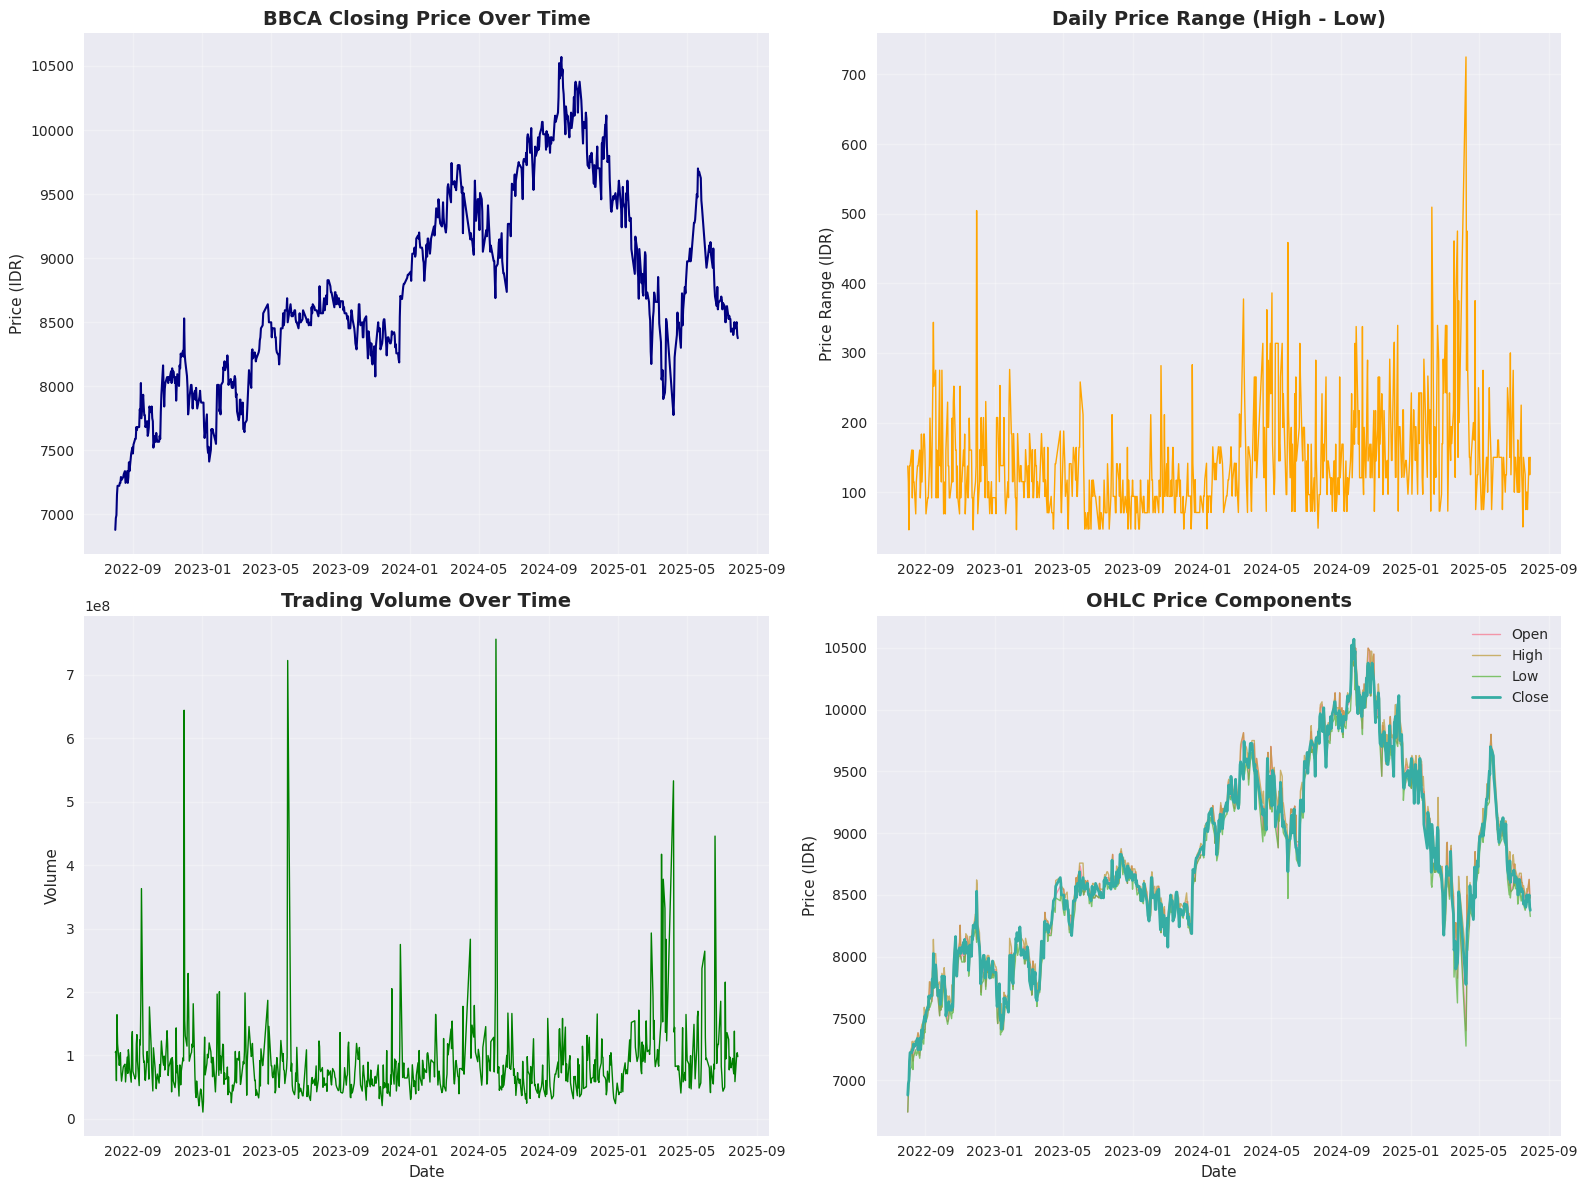

In [23]:
## 3. Data Visualization

# 3.1 Price Trends Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Closing price over time
axes[0, 0].plot(df.index, df['Close'], color='navy', linewidth=1.5)
axes[0, 0].set_title('BBCA Closing Price Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price (IDR)')
axes[0, 0].grid(True, alpha=0.3)

# Daily price range (High - Low)
daily_range = df['High'] - df['Low']
axes[0, 1].plot(df.index, daily_range, color='orange', linewidth=1)
axes[0, 1].set_title('Daily Price Range (High - Low)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price Range (IDR)')
axes[0, 1].grid(True, alpha=0.3)

# Volume over time
axes[1, 0].plot(df.index, df['Volume'], color='green', linewidth=1)
axes[1, 0].set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Volume')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

# OHLC candlestick-style visualization
axes[1, 1].plot(df.index, df['Open'], label='Open', alpha=0.7, linewidth=1)
axes[1, 1].plot(df.index, df['High'], label='High', alpha=0.7, linewidth=1)
axes[1, 1].plot(df.index, df['Low'], label='Low', alpha=0.7, linewidth=1)
axes[1, 1].plot(df.index, df['Close'], label='Close', linewidth=2)
axes[1, 1].set_title('OHLC Price Components', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Price (IDR)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

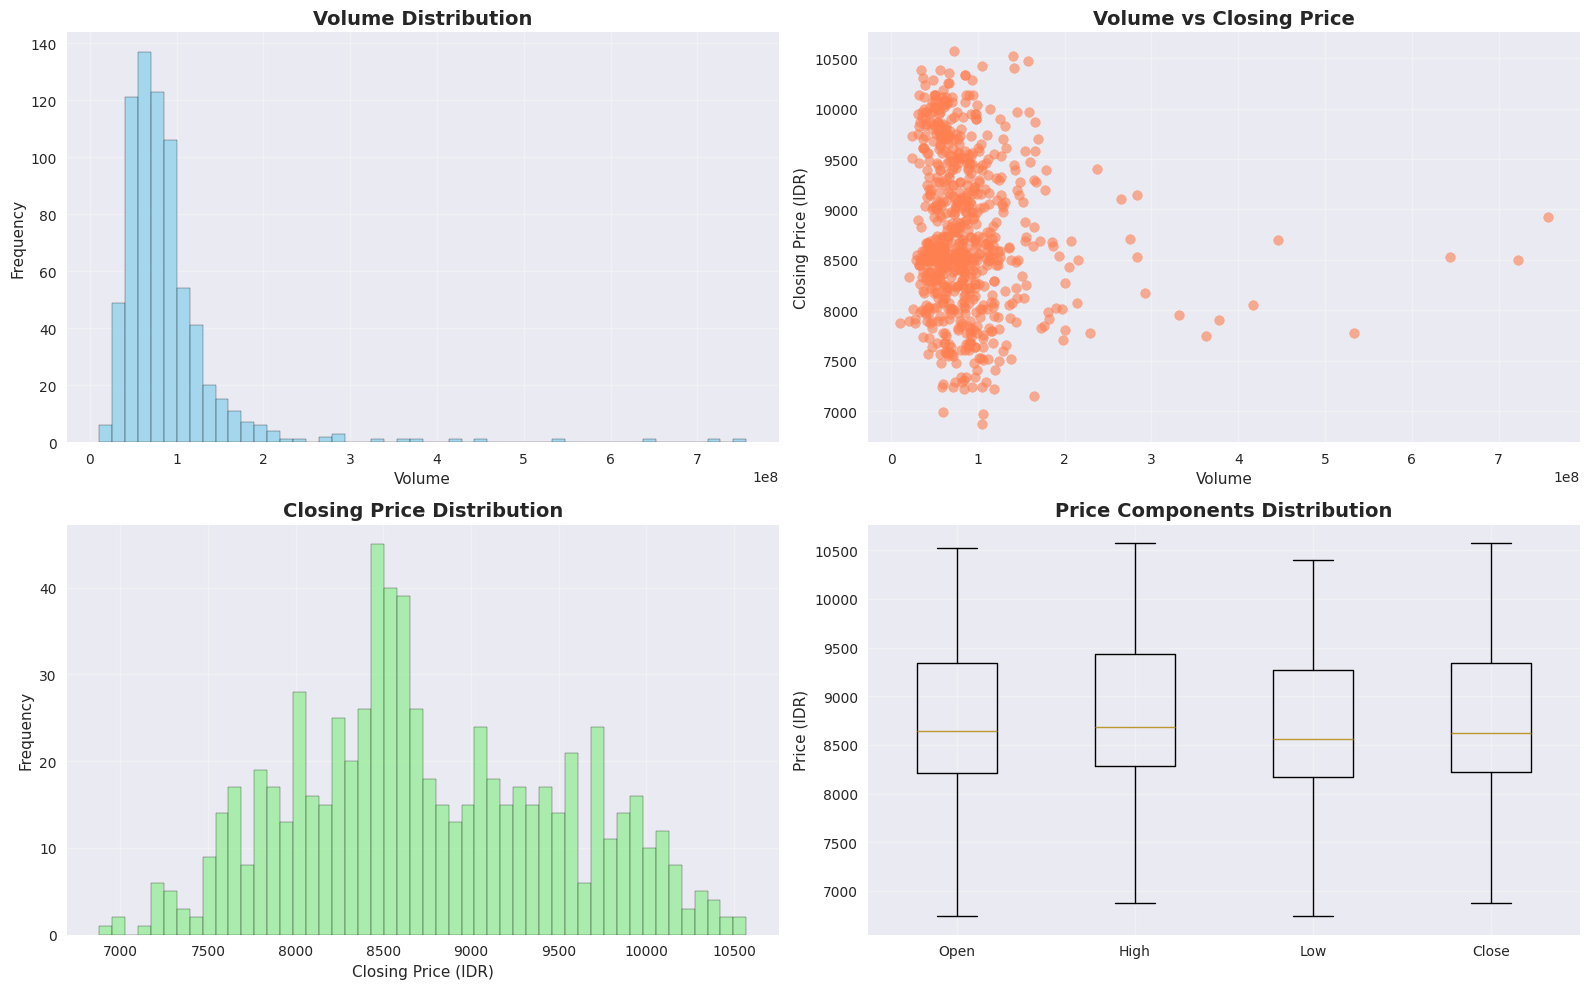

In [24]:
# 3.2 Volume Analysis and Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Volume histogram
axes[0, 0].hist(df['Volume'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Volume Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Volume vs Price relationship
axes[0, 1].scatter(df['Volume'], df['Close'], alpha=0.6, color='coral')
axes[0, 1].set_title('Volume vs Closing Price', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_ylabel('Closing Price (IDR)')
axes[0, 1].grid(True, alpha=0.3)

# Price distribution
axes[1, 0].hist(df['Close'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Closing Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Closing Price (IDR)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Box plot for price components
price_data = [df['Open'], df['High'], df['Low'], df['Close']]
axes[1, 1].boxplot(price_data, labels=['Open', 'High', 'Low', 'Close'])
axes[1, 1].set_title('Price Components Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Price (IDR)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
## 4. Extreme Values and Market Event Analysis

# 4.1 Volume Extremes Analysis
print("VOLUME EXTREMES ANALYSIS")
print("=" * 75)

# Identify volume spikes (99th percentile)
volume_99th = df['Volume'].quantile(0.99)
volume_spikes = df[df['Volume'] > volume_99th].copy()
volume_spikes['Price_Change_Pct'] = volume_spikes['Close'].pct_change() * 100

print(f"Volume Spike Threshold (99th percentile): {volume_99th:,.0f}")
print(f"Number of volume spike days: {len(volume_spikes)}")

print(f"\nTop 10 Highest Volume Trading Days:")
top_volume = df.nlargest(10, 'Volume')[['Volume', 'Close', 'High', 'Low', 'Open']]
top_volume['Daily_Range_Pct'] = ((top_volume['High'] - top_volume['Low']) / top_volume['Close'] * 100).round(2)
print(top_volume)

# 4.2 Price Extremes Analysis  
print(f"\nPRICE EXTREMES ANALYSIS")
print("=" * 50)

print(f"Top 10 Highest Closing Prices:")
top_prices = df.nlargest(10, 'Close')[['Close', 'Volume', 'High', 'Low', 'Open']]
top_prices['Volume_vs_Avg'] = (top_prices['Volume'] / df['Volume'].mean()).round(2)
print(top_prices)

print(f"\nTop 10 Lowest Closing Prices:")
low_prices = df.nsmallest(10, 'Close')[['Close', 'Volume', 'High', 'Low', 'Open']]
low_prices['Volume_vs_Avg'] = (low_prices['Volume'] / df['Volume'].mean()).round(2)
print(low_prices)


VOLUME EXTREMES ANALYSIS
Volume Spike Threshold (99th percentile): 358,433,980
Number of volume spike days: 8

Top 10 Highest Volume Trading Days:
               Volume        Close         High          Low         Open  \
Date                                                                        
2024-05-31  756431600  8929.344727  8929.344727  8712.144449  8784.544542   
2023-05-31  722827900  8498.944336  8757.199551  8498.944336  8733.721804   
2022-11-30  644359600  8529.272461  8620.985068  8116.565729  8139.493881   
2025-04-08  533073600  7775.000000  8000.000000  7275.000000  7400.000000   
2025-06-20  445915100  8700.000000  8875.000000  8625.000000  8700.000000   
2025-03-18  417305700  8052.238770  8294.776082  7833.955188  8246.268619   
2025-03-21  377916400  7900.000000  8275.000000  7900.000000  8275.000000   
2022-09-16  363127600  7749.715820  8001.925507  7749.715820  7978.997353   
2025-03-24  331836800  7950.000000  8100.000000  7625.000000  7825.000000   
2025-0


DETAILED VOLUME SPIKE ANALYSIS
Volume Spike Events (Volume > 99th percentile):
               Volume        Close         Open         High          Low  \
Date                                                                        
2024-05-31  756431600  8929.344727  8784.544542  8929.344727  8712.144449   
2023-05-31  722827900  8498.944336  8733.721804  8757.199551  8498.944336   
2022-11-30  644359600  8529.272461  8139.493881  8620.985068  8116.565729   
2025-04-08  533073600  7775.000000  7400.000000  8000.000000  7275.000000   
2025-06-20  445915100  8700.000000  8700.000000  8875.000000  8625.000000   
2025-03-18  417305700  8052.238770  8246.268619  8294.776082  7833.955188   
2025-03-21  377916400  7900.000000  8275.000000  8275.000000  7900.000000   
2022-09-16  363127600  7749.715820  7978.997353  8001.925507  7749.715820   

            Daily_Return_Pct  Intraday_Range_Pct  Volume_Multiple  
Date                                                               
2024-05-31   

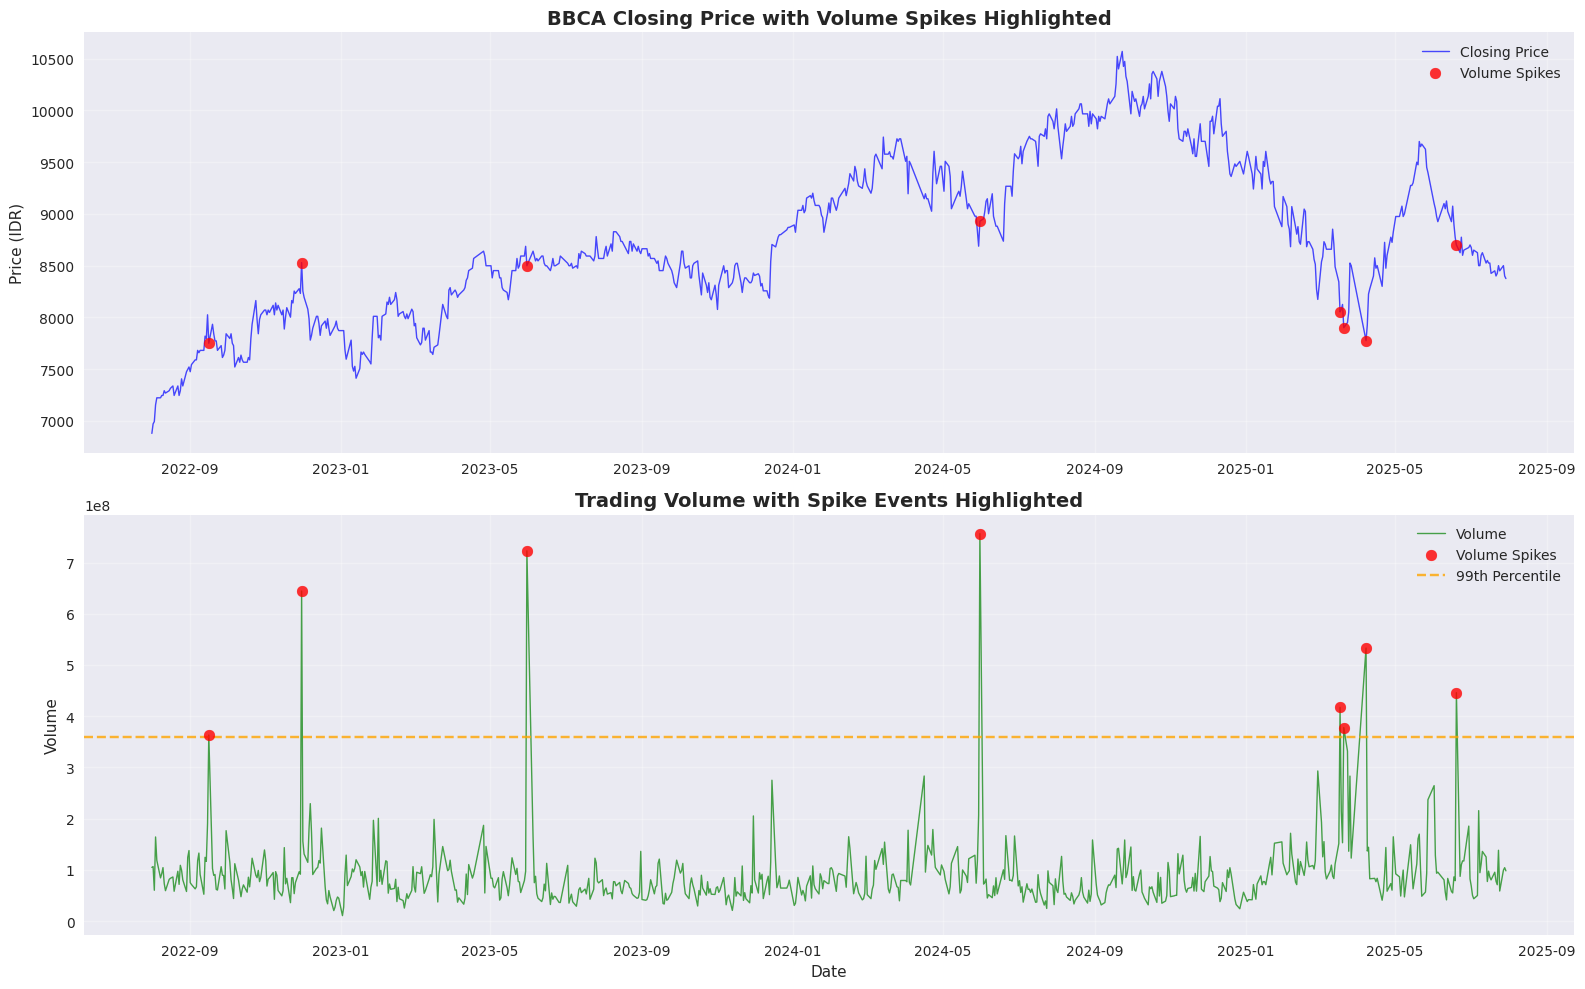

In [26]:
# 4.3 Volume Spike Detailed Analysis
print(f"\nDETAILED VOLUME SPIKE ANALYSIS")
print("=" * 75)

# Calculate additional metrics for volume spikes
volume_spikes = df[df['Volume'] > df['Volume'].quantile(0.99)].copy()
volume_spikes['Daily_Return_Pct'] = ((volume_spikes['Close'] - volume_spikes['Open']) / volume_spikes['Open'] * 100).round(2)
volume_spikes['Intraday_Range_Pct'] = ((volume_spikes['High'] - volume_spikes['Low']) / volume_spikes['Open'] * 100).round(2)
volume_spikes['Volume_Multiple'] = (volume_spikes['Volume'] / df['Volume'].mean()).round(2)

# Sort by volume and display
volume_spikes_display = volume_spikes[['Volume', 'Close', 'Open', 'High', 'Low', 'Daily_Return_Pct', 'Intraday_Range_Pct', 'Volume_Multiple']].sort_values('Volume', ascending=False)

print(f"Volume Spike Events (Volume > 99th percentile):")
print(volume_spikes_display)

# Visualize volume spikes
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Price with volume spikes highlighted
axes[0].plot(df.index, df['Close'], color='blue', linewidth=1, alpha=0.7, label='Closing Price')
axes[0].scatter(volume_spikes.index, volume_spikes['Close'], color='red', s=60, alpha=0.8, label='Volume Spikes', zorder=5)
axes[0].set_title('BBCA Closing Price with Volume Spikes Highlighted', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (IDR)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume with spikes highlighted
axes[1].plot(df.index, df['Volume'], color='green', linewidth=1, alpha=0.7, label='Volume')
axes[1].scatter(volume_spikes.index, volume_spikes['Volume'], color='red', s=60, alpha=0.8, label='Volume Spikes', zorder=5)
axes[1].axhline(y=df['Volume'].quantile(0.99), color='orange', linestyle='--', alpha=0.8, label='99th Percentile')
axes[1].set_title('Trading Volume with Spike Events Highlighted', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

RETURNS ANALYSIS
Daily Return Statistics:
   • Mean daily return: 0.0004 (0.04%)
   • Median daily return: 0.0000 (0.00%)
   • Standard deviation: 0.0140 (1.40%)
   • Annualized volatility: 0.2215 (22.15%)
   • Skewness: 0.0589
   • Kurtosis: 2.7148

Extreme Return Days:
   • Largest gain: 0.0590 (5.90%) on 2025-03-26 00:00:00
   • Largest loss: -0.0853 (-8.53%) on 2025-04-08 00:00:00


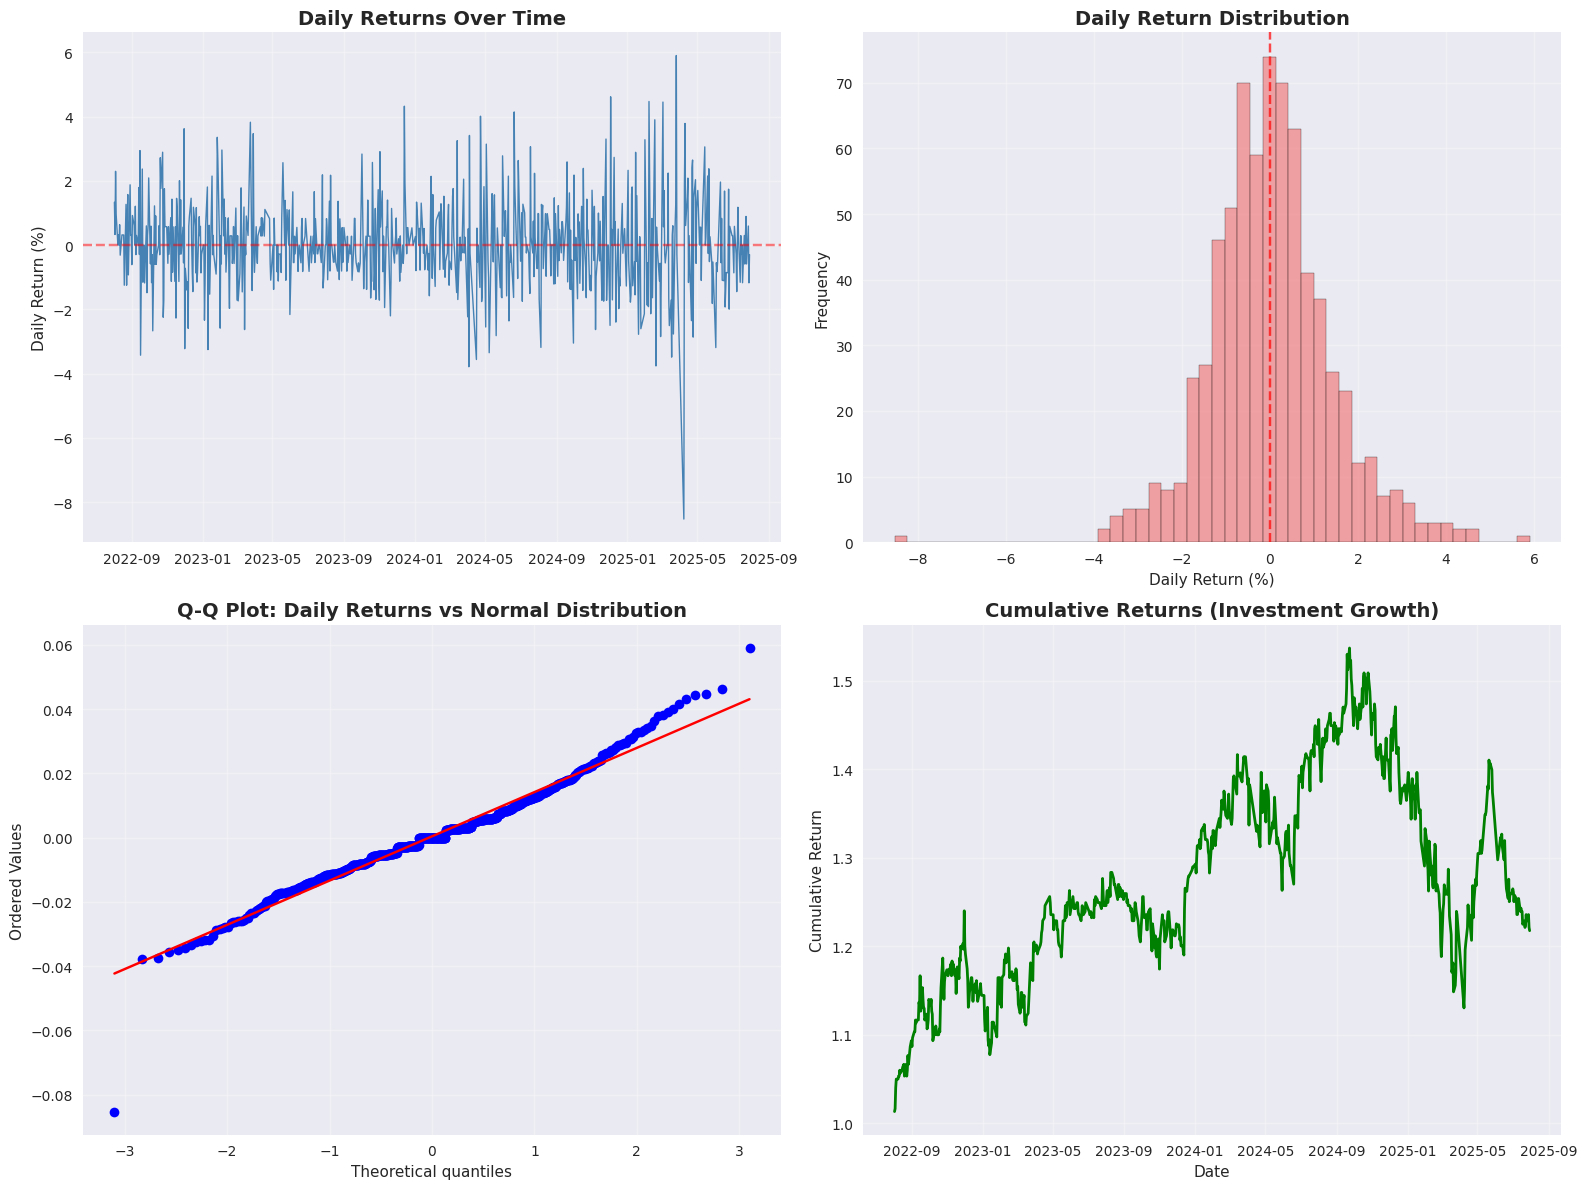

In [27]:
## 5. Returns and Volatility Analysis

# 5.1 Calculate Daily Returns
print("RETURNS ANALYSIS")
print("=" * 75)

# Calculate various return metrics
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Intraday_Return'] = (df['Close'] - df['Open']) / df['Open']
df['Overnight_Return'] = (df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)

# Return statistics
print(f"Daily Return Statistics:")
print(f"   • Mean daily return: {df['Daily_Return'].mean():.4f} ({df['Daily_Return'].mean()*100:.2f}%)")
print(f"   • Median daily return: {df['Daily_Return'].median():.4f} ({df['Daily_Return'].median()*100:.2f}%)")
print(f"   • Standard deviation: {df['Daily_Return'].std():.4f} ({df['Daily_Return'].std()*100:.2f}%)")
print(f"   • Annualized volatility: {df['Daily_Return'].std() * np.sqrt(252):.4f} ({df['Daily_Return'].std() * np.sqrt(252)*100:.2f}%)")
print(f"   • Skewness: {df['Daily_Return'].skew():.4f}")
print(f"   • Kurtosis: {df['Daily_Return'].kurtosis():.4f}")

# Extreme returns
print(f"\nExtreme Return Days:")
print(f"   • Largest gain: {df['Daily_Return'].max():.4f} ({df['Daily_Return'].max()*100:.2f}%) on {df['Daily_Return'].idxmax()}")
print(f"   • Largest loss: {df['Daily_Return'].min():.4f} ({df['Daily_Return'].min()*100:.2f}%) on {df['Daily_Return'].idxmin()}")

# 5.2 Return Distribution Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Daily returns time series
axes[0, 0].plot(df.index, df['Daily_Return'] * 100, color='steelblue', linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Daily Returns Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Daily Return (%)')
axes[0, 0].grid(True, alpha=0.3)

# Return distribution histogram
axes[0, 1].hist(df['Daily_Return'].dropna() * 100, bins=50, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Daily Return Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Daily Return (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot for normality check
stats.probplot(df['Daily_Return'].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Daily Returns vs Normal Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Cumulative returns
cumulative_returns = (1 + df['Daily_Return']).cumprod()
axes[1, 1].plot(df.index, cumulative_returns, color='green', linewidth=2)
axes[1, 1].set_title('Cumulative Returns (Investment Growth)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

TECHNICAL INDICATORS ANALYSIS
Technical indicators calculated:
   • Simple Moving Averages (5, 10, 20, 50, 200)
   • Exponential Moving Averages (12, 26)
   • MACD with signal line and histogram
   • RSI (14-period)
   • Bollinger Bands (20-period, 2 std)
   • Average True Range (ATR)


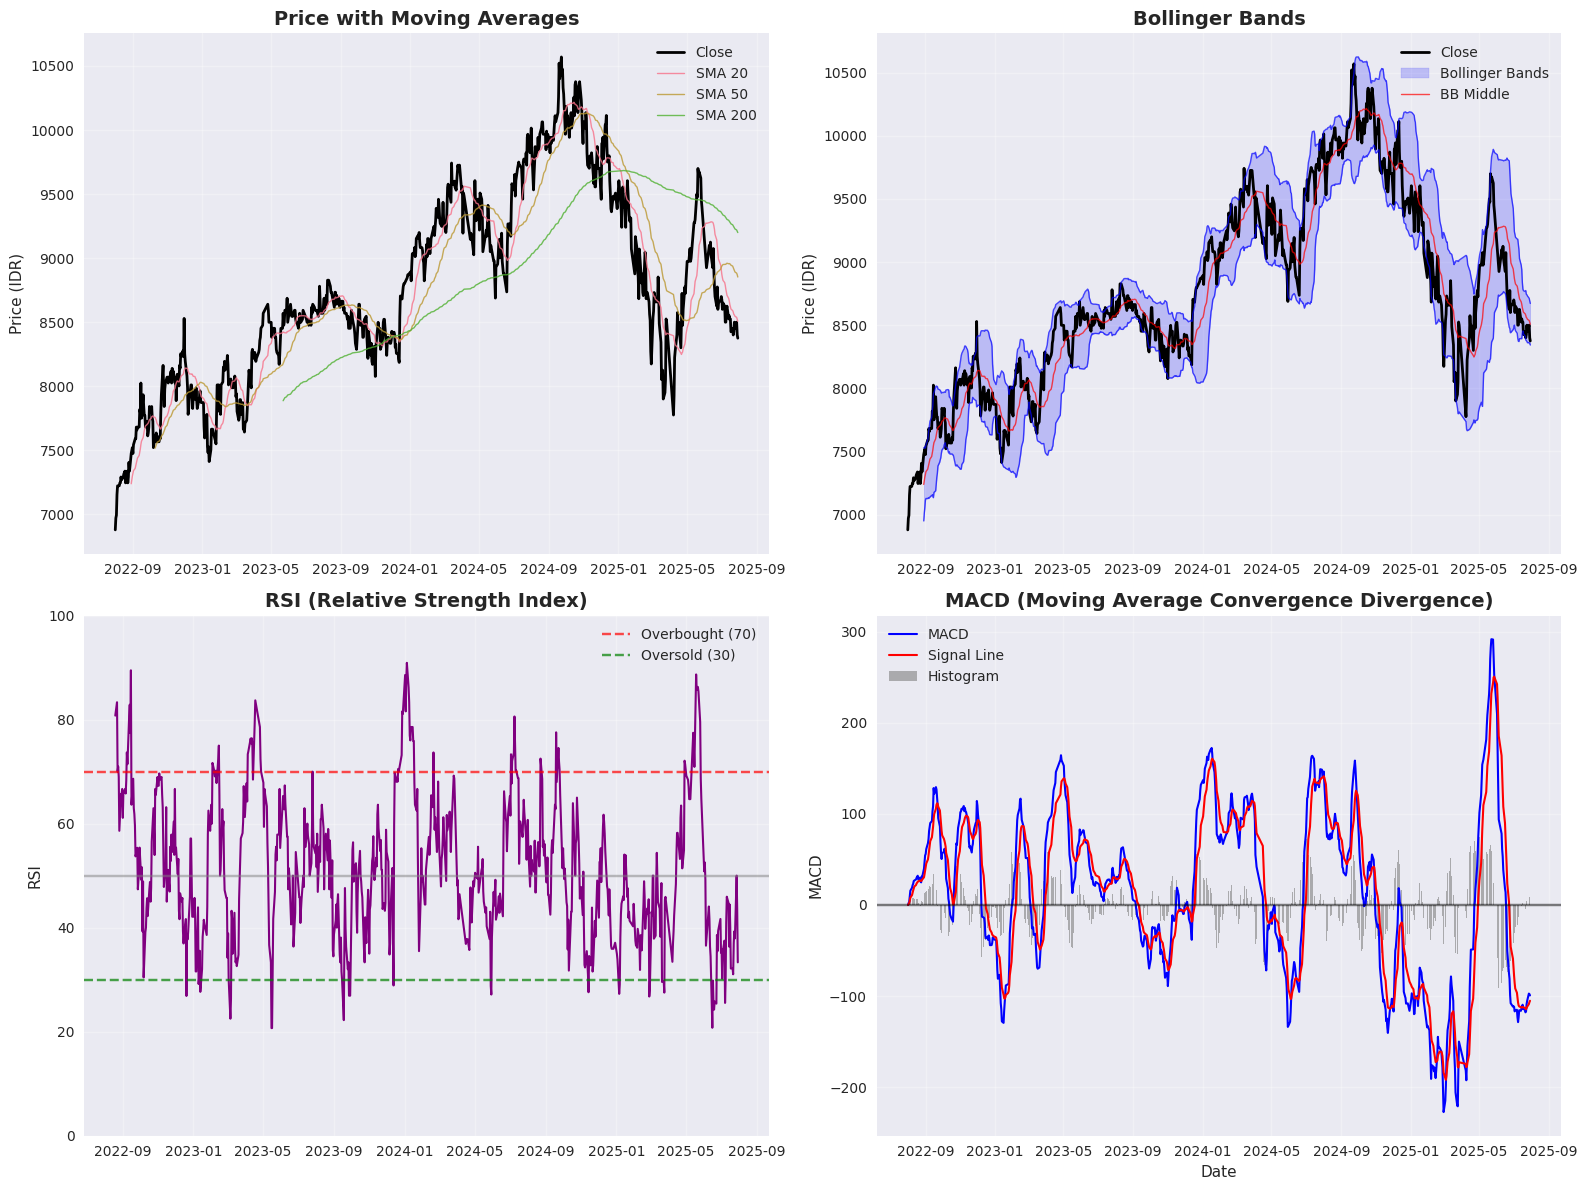

In [28]:
## 6. Technical Indicators Analysis

# 6.1 Moving Averages
print("TECHNICAL INDICATORS ANALYSIS")
print("=" * 75)

# Calculate various moving averages
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Exponential Moving Averages
df['EMA_12'] = df['Close'].ewm(span=12).mean()
df['EMA_26'] = df['Close'].ewm(span=26).mean()

# 6.2 MACD (Moving Average Convergence Divergence)
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# 6.3 RSI (Relative Strength Index)
def calculate_rsi(price_series, window=14):
    """Calculate RSI indicator"""
    delta = price_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# 6.4 Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# 6.5 Volatility Indicators
df['ATR_High_Low'] = df['High'] - df['Low']
df['ATR_High_Close'] = abs(df['High'] - df['Close'].shift(1))
df['ATR_Low_Close'] = abs(df['Low'] - df['Close'].shift(1))
df['True_Range'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)
df['ATR'] = df['True_Range'].rolling(window=14).mean()

print("Technical indicators calculated:")
print("   • Simple Moving Averages (5, 10, 20, 50, 200)")
print("   • Exponential Moving Averages (12, 26)")
print("   • MACD with signal line and histogram")
print("   • RSI (14-period)")
print("   • Bollinger Bands (20-period, 2 std)")
print("   • Average True Range (ATR)")

# Technical Indicators Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Moving averages with price
axes[0, 0].plot(df.index, df['Close'], label='Close', linewidth=2, color='black')
axes[0, 0].plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, alpha=0.8)
axes[0, 0].plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1, alpha=0.8)
axes[0, 0].plot(df.index, df['SMA_200'], label='SMA 200', linewidth=1, alpha=0.8)
axes[0, 0].set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price (IDR)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bollinger Bands
axes[0, 1].plot(df.index, df['Close'], label='Close', linewidth=2, color='black')
axes[0, 1].fill_between(df.index, df['BB_Upper'], df['BB_Lower'], alpha=0.2, color='blue', label='Bollinger Bands')
axes[0, 1].plot(df.index, df['BB_Upper'], color='blue', linewidth=1, alpha=0.7)
axes[0, 1].plot(df.index, df['BB_Lower'], color='blue', linewidth=1, alpha=0.7)
axes[0, 1].plot(df.index, df['BB_Middle'], color='red', linewidth=1, alpha=0.7, label='BB Middle')
axes[0, 1].set_title('Bollinger Bands', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price (IDR)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# RSI
axes[1, 0].plot(df.index, df['RSI'], color='purple', linewidth=1.5)
axes[1, 0].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1, 0].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1, 0].axhline(y=50, color='gray', linestyle='-', alpha=0.5)
axes[1, 0].set_title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MACD
axes[1, 1].plot(df.index, df['MACD'], label='MACD', linewidth=1.5, color='blue')
axes[1, 1].plot(df.index, df['MACD_Signal'], label='Signal Line', linewidth=1.5, color='red')
axes[1, 1].bar(df.index, df['MACD_Histogram'], label='Histogram', alpha=0.6, color='gray', width=1)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('MACD (Moving Average Convergence Divergence)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('MACD')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FEATURE ENGINEERING
Feature engineering completed:
   • Lag features: Price, Volume, High, Low, Returns (1-5 days)
   • Rolling statistics: Mean, Std, Min, Max (3, 5, 10, 20 days)
   • Price change features: Absolute and percentage changes
   • Relative position features: vs Moving averages, vs ranges
   • Volume features: Relative volume, volume changes
   • Time-based features: Day, Month, Quarter, Year
   • Volatility features: Rolling volatility, price ranges
   • Momentum features: Price and volume momentum

Total features created: 114
Data shape after feature engineering: (716, 114)


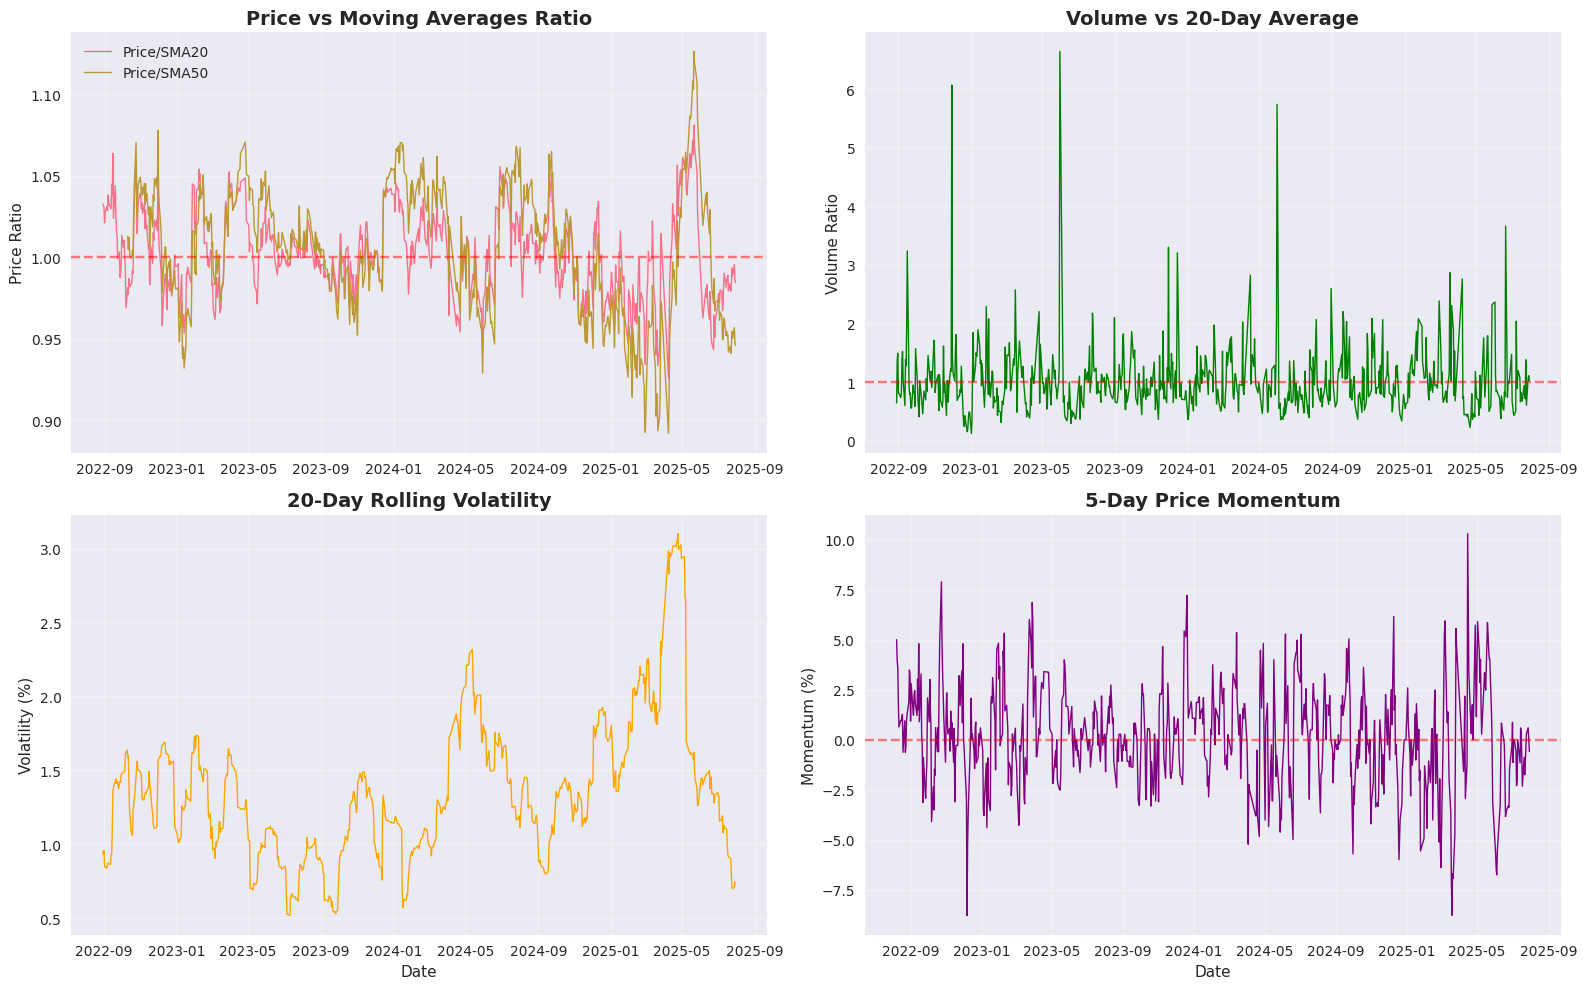

In [29]:
## 7. Feature Engineering for Time Series Forecasting

# 7.1 Lag Features
print("FEATURE ENGINEERING")
print("=" * 75)

# Price lag features
for lag in range(1, 6):
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
    df[f'High_Lag_{lag}'] = df['High'].shift(lag)
    df[f'Low_Lag_{lag}'] = df['Low'].shift(lag)

# Return lag features  
for lag in range(1, 6):
    df[f'Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)

# 7.2 Rolling Statistics Features
windows = [3, 5, 10, 20]
for window in windows:
    # Rolling price statistics
    df[f'Close_Rolling_Mean_{window}'] = df['Close'].rolling(window).mean()
    df[f'Close_Rolling_Std_{window}'] = df['Close'].rolling(window).std()
    df[f'Close_Rolling_Min_{window}'] = df['Close'].rolling(window).min()
    df[f'Close_Rolling_Max_{window}'] = df['Close'].rolling(window).max()
    
    # Rolling volume statistics
    df[f'Volume_Rolling_Mean_{window}'] = df['Volume'].rolling(window).mean()
    df[f'Volume_Rolling_Std_{window}'] = df['Volume'].rolling(window).std()
    
    # Rolling return statistics
    df[f'Return_Rolling_Mean_{window}'] = df['Daily_Return'].rolling(window).mean()
    df[f'Return_Rolling_Std_{window}'] = df['Daily_Return'].rolling(window).std()

# 7.3 Price Change Features
df['Price_Change_1D'] = df['Close'] - df['Close_Lag_1']
df['Price_Change_3D'] = df['Close'] - df['Close_Lag_3'] 
df['Price_Change_5D'] = df['Close'] - df['Close_Lag_5']

df['Price_Change_Pct_1D'] = (df['Close'] - df['Close_Lag_1']) / df['Close_Lag_1']
df['Price_Change_Pct_3D'] = (df['Close'] - df['Close_Lag_3']) / df['Close_Lag_3']
df['Price_Change_Pct_5D'] = (df['Close'] - df['Close_Lag_5']) / df['Close_Lag_5']

# 7.4 Relative Position Features
df['Price_vs_SMA20'] = df['Close'] / df['SMA_20']
df['Price_vs_SMA50'] = df['Close'] / df['SMA_50']
df['Price_vs_High_20D'] = df['Close'] / df['Close_Rolling_Max_20']
df['Price_vs_Low_20D'] = df['Close'] / df['Close_Rolling_Min_20']

# 7.5 Volume Features
df['Volume_vs_MA'] = df['Volume'] / df['Volume_Rolling_Mean_20']
df['Volume_Change_1D'] = df['Volume'] - df['Volume_Lag_1']
df['Volume_Change_Pct_1D'] = (df['Volume'] - df['Volume_Lag_1']) / df['Volume_Lag_1']

# 7.6 Time-based Features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year
df['DayOfYear'] = df.index.dayofyear

# 7.7 Volatility Features
for window in [5, 10, 20]:
    df[f'Volatility_{window}D'] = df['Daily_Return'].rolling(window).std()
    df[f'Price_Range_{window}D'] = (df['High'] - df['Low']).rolling(window).mean()

# 7.8 Momentum Features
df['Price_Momentum_3D'] = df['Close'] / df['Close_Lag_3'] - 1
df['Price_Momentum_5D'] = df['Close'] / df['Close_Lag_5'] - 1
df['Volume_Momentum_3D'] = df['Volume'] / df['Volume_Lag_3'] - 1

print("Feature engineering completed:")
print(f"   • Lag features: Price, Volume, High, Low, Returns (1-5 days)")
print(f"   • Rolling statistics: Mean, Std, Min, Max (3, 5, 10, 20 days)")
print(f"   • Price change features: Absolute and percentage changes")
print(f"   • Relative position features: vs Moving averages, vs ranges")
print(f"   • Volume features: Relative volume, volume changes")
print(f"   • Time-based features: Day, Month, Quarter, Year")
print(f"   • Volatility features: Rolling volatility, price ranges")
print(f"   • Momentum features: Price and volume momentum")

print(f"\nTotal features created: {df.shape[1]}")
print(f"Data shape after feature engineering: {df.shape}")

# Visualize some key engineered features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price vs moving averages ratio
axes[0, 0].plot(df.index, df['Price_vs_SMA20'], label='Price/SMA20', linewidth=1)
axes[0, 0].plot(df.index, df['Price_vs_SMA50'], label='Price/SMA50', linewidth=1) 
axes[0, 0].axhline(y=1, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Price vs Moving Averages Ratio', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Price Ratio')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volume momentum
axes[0, 1].plot(df.index, df['Volume_vs_MA'], linewidth=1, color='green')
axes[0, 1].axhline(y=1, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Volume vs 20-Day Average', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Volume Ratio')
axes[0, 1].grid(True, alpha=0.3)

# Rolling volatility
axes[1, 0].plot(df.index, df['Volatility_20D'] * 100, linewidth=1, color='orange')
axes[1, 0].set_title('20-Day Rolling Volatility', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Volatility (%)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

# Price momentum
axes[1, 1].plot(df.index, df['Price_Momentum_5D'] * 100, linewidth=1, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('5-Day Price Momentum', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Momentum (%)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

CORRELATION ANALYSIS


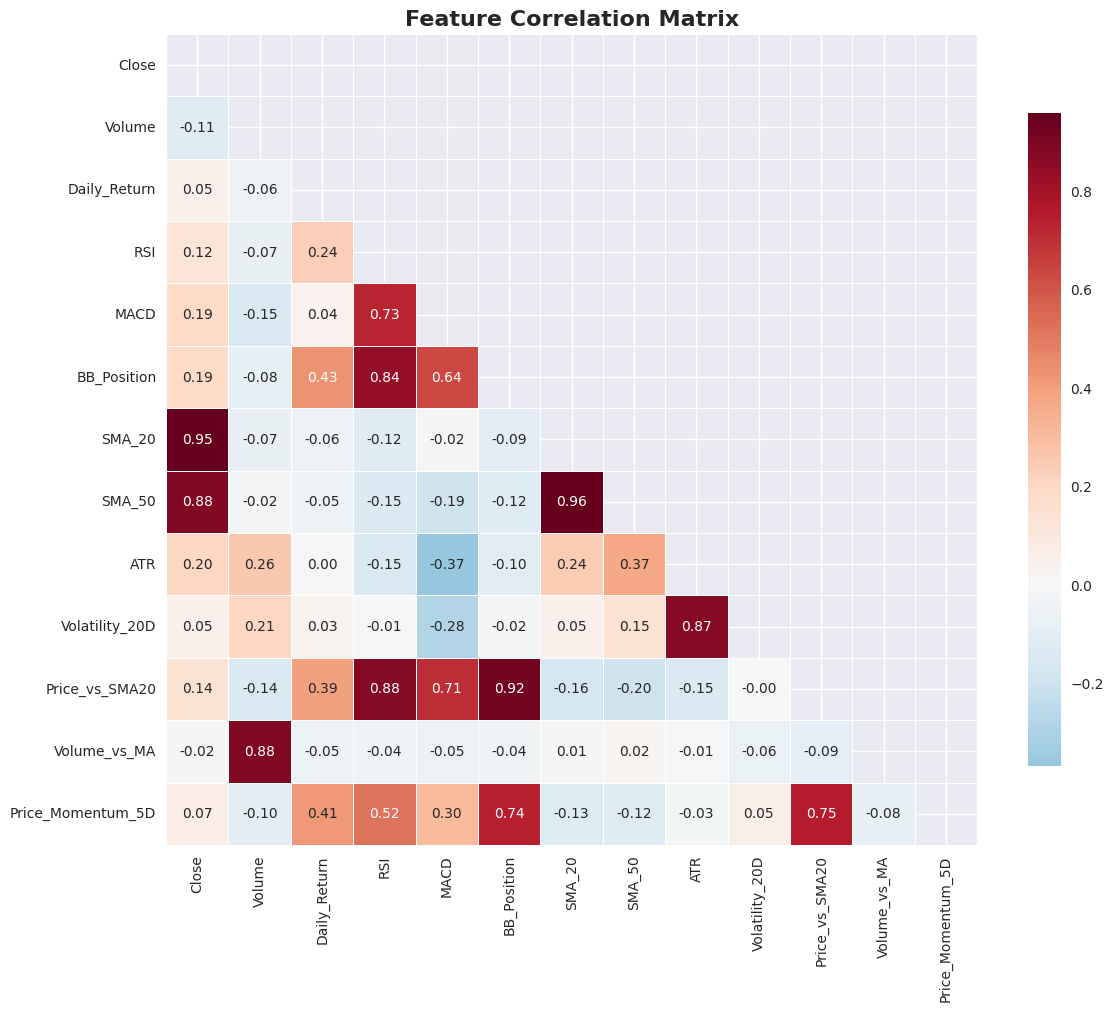

Highly Correlated Feature Pairs (|correlation| > 0.7):
   • Close ↔ SMA_20: 0.953
   • Close ↔ SMA_50: 0.882
   • Volume ↔ Volume_vs_MA: 0.881
   • RSI ↔ MACD: 0.726
   • RSI ↔ BB_Position: 0.836
   • RSI ↔ Price_vs_SMA20: 0.875
   • MACD ↔ Price_vs_SMA20: 0.706
   • BB_Position ↔ Price_vs_SMA20: 0.923
   • BB_Position ↔ Price_Momentum_5D: 0.743
   • SMA_20 ↔ SMA_50: 0.958
   • ATR ↔ Volatility_20D: 0.867
   • Price_vs_SMA20 ↔ Price_Momentum_5D: 0.748

Price vs Volume Relationship:
   • Overall correlation: -0.109
   • Volume statistics by price quintiles:
                        mean      median           std
Price_Quintile                                        
Q1              9.896797e+07  86136900.0  7.090009e+07
Q2              8.540159e+07  76325700.0  6.670958e+07
Q3              9.139285e+07  76116750.0  7.072279e+07
Q4              9.325777e+07  82087300.0  6.874038e+07
Q5              7.151770e+07  62646500.0  3.206369e+07


In [30]:
## 8. Correlation Analysis

# 8.1 Feature Correlation Matrix
print("CORRELATION ANALYSIS")
print("=" * 75)

# Select key features for correlation analysis
correlation_features = [
    'Close', 'Volume', 'Daily_Return', 'RSI', 'MACD', 'BB_Position',
    'SMA_20', 'SMA_50', 'ATR', 'Volatility_20D',
    'Price_vs_SMA20', 'Volume_vs_MA', 'Price_Momentum_5D'
]

# Calculate correlation matrix
corr_matrix = df[correlation_features].corr()

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
print("Highly Correlated Feature Pairs (|correlation| > 0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for feature1, feature2, correlation in high_corr_pairs:
    print(f"   • {feature1} ↔ {feature2}: {correlation:.3f}")

# 8.2 Price vs Volume Relationship Analysis
print(f"\nPrice vs Volume Relationship:")
price_volume_corr = df['Close'].corr(df['Volume'])
print(f"   • Overall correlation: {price_volume_corr:.3f}")

# Volume analysis by price quintiles
df['Price_Quintile'] = pd.qcut(df['Close'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
volume_by_quintile = df.groupby('Price_Quintile')['Volume'].agg(['mean', 'median', 'std'])
print(f"   • Volume statistics by price quintiles:")
print(volume_by_quintile)

OUTLIER DETECTION ANALYSIS
Outlier Detection Results:
   • Return outliers (Z-score): 6
   • Return outliers (IQR): 26
   • Volume outliers (Z-score): 12
   • Volume outliers (IQR): 39

Top Extreme Return Events:
   • 2025-04-08: -8.53% return, Volume: 533,073,600
   • 2025-03-26: 5.90% return, Volume: 283,104,600
   • 2024-12-03: 4.62% return, Volume: 126,087,100
   • 2025-02-07: 4.47% return, Volume: 131,162,200
   • 2025-03-03: 4.45% return, Volume: 192,944,300
   • 2023-12-14: 4.32% return, Volume: 115,332,800

SEASONALITY ANALYSIS
Day of Week Analysis:
   • Monday: Avg return 0.06%, Avg volume 78,158,367
   • Tuesday: Avg return -0.12%, Avg volume 85,130,730
   • Wednesday: Avg return 0.08%, Avg volume 94,691,540
   • Thursday: Avg return 0.12%, Avg volume 86,970,418
   • Friday: Avg return 0.04%, Avg volume 95,934,242

Monthly Performance:
   • Jan: Avg return -0.02%, Avg volume 81,165,550
   • Feb: Avg return -0.08%, Avg volume 90,935,766
   • Mar: Avg return 0.19%, Avg volume 1

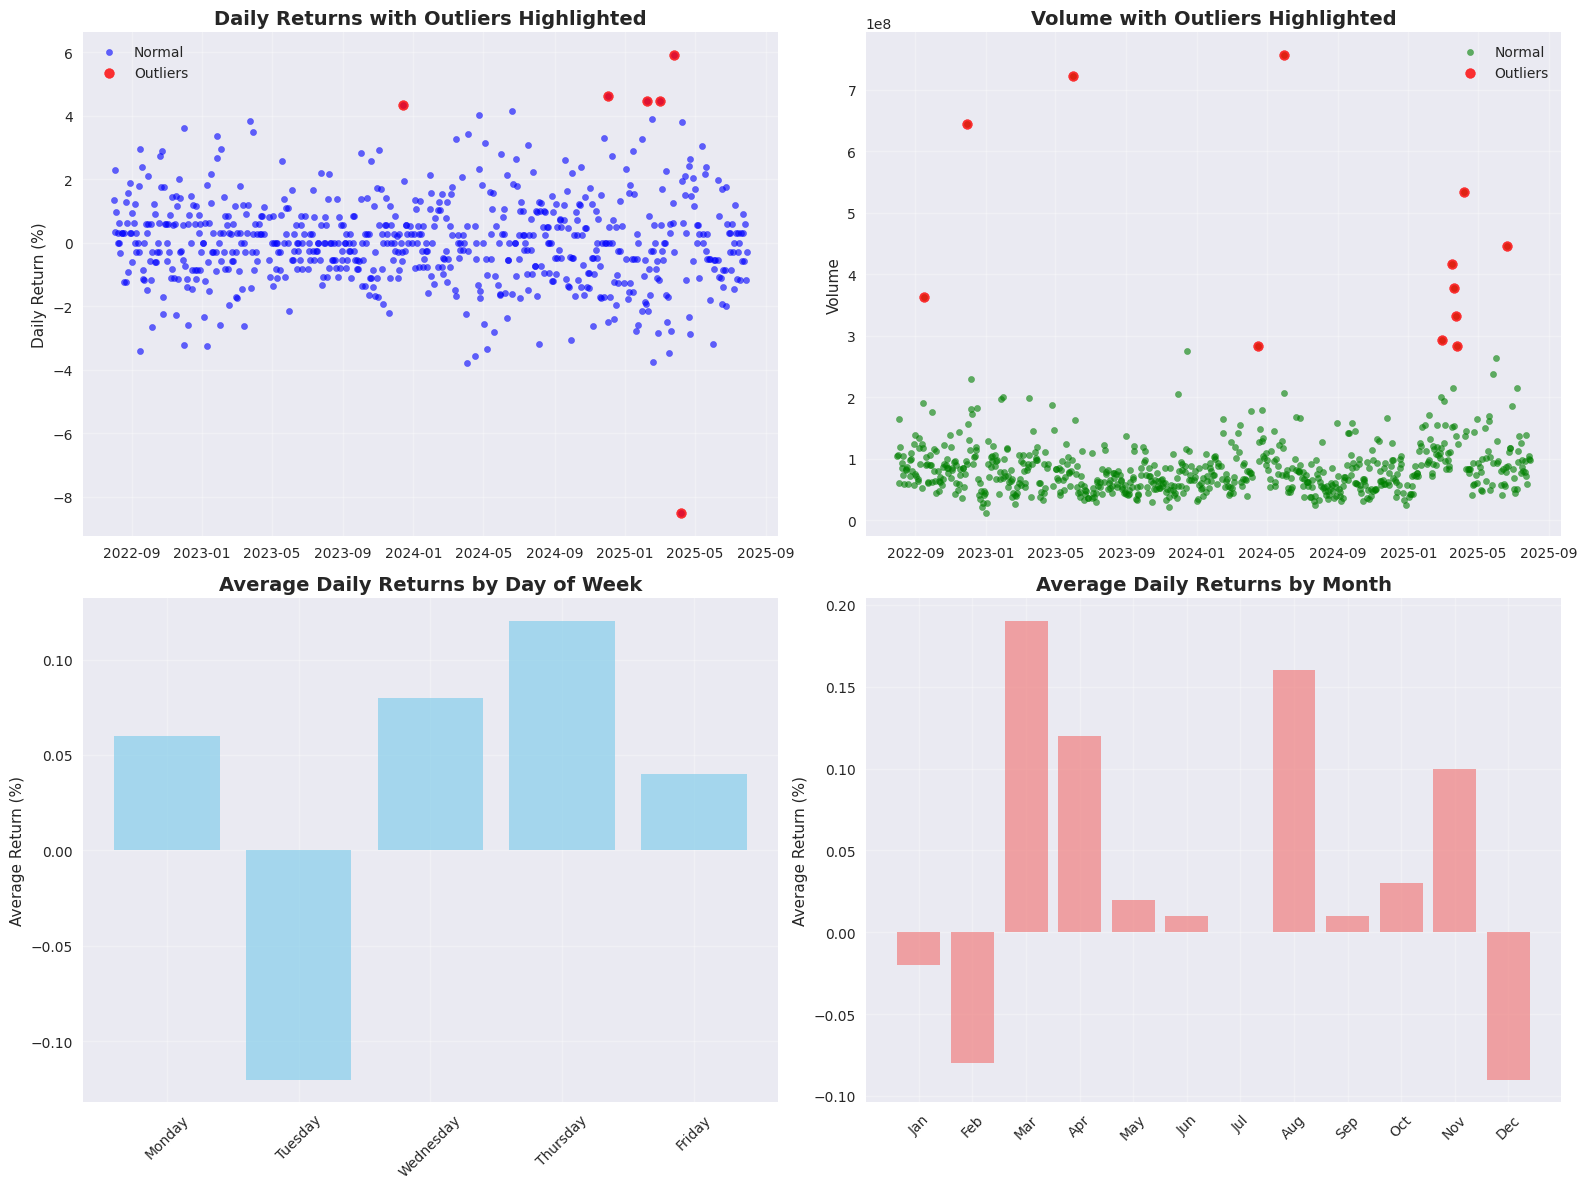

In [31]:
## 9. Outlier Detection and Anomaly Analysis

# 9.1 Statistical Outlier Detection
print("OUTLIER DETECTION ANALYSIS")
print("=" * 75)

# Z-score based outlier detection for returns
def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score and return full-length boolean Series"""
    z_scores = np.abs(stats.zscore(data.dropna()))
    mask = pd.Series(z_scores > threshold, index=data.dropna().index)
    return mask.reindex(data.index, fill_value=False)

# IQR based outlier detection
def detect_outliers_iqr(data):
    """Detect outliers using Interquartile Range method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect outliers in daily returns
return_outliers_zscore = detect_outliers_zscore(df['Daily_Return'])
return_outliers_iqr = detect_outliers_iqr(df['Daily_Return'])

# Detect outliers in volume
volume_outliers_zscore = detect_outliers_zscore(df['Volume'])
volume_outliers_iqr = detect_outliers_iqr(df['Volume'])

print(f"Outlier Detection Results:")
print(f"   • Return outliers (Z-score): {return_outliers_zscore.sum()}")
print(f"   • Return outliers (IQR): {return_outliers_iqr.sum()}")
print(f"   • Volume outliers (Z-score): {volume_outliers_zscore.sum()}")
print(f"   • Volume outliers (IQR): {volume_outliers_iqr.sum()}")

# Extreme return events
extreme_returns = df[return_outliers_zscore].copy()
if len(extreme_returns) > 0:
    extreme_returns['Abs_Return'] = abs(extreme_returns['Daily_Return'])
    extreme_returns = extreme_returns.sort_values('Abs_Return', ascending=False)
    
    print(f"\nTop Extreme Return Events:")
    top_extreme = extreme_returns[['Daily_Return', 'Close', 'Volume', 'RSI', 'MACD']].head(10)
    for idx, row in top_extreme.iterrows():
        print(f"   • {idx.date()}: {row['Daily_Return']*100:.2f}% return, Volume: {row['Volume']:,.0f}")

# 9.2 Seasonality and Pattern Analysis
print(f"\nSEASONALITY ANALYSIS")
print("=" * 75)

# Day of week analysis
dow_analysis = df.groupby('DayOfWeek').agg({
    'Daily_Return': ['mean', 'std', 'count'],
    'Volume': 'mean'
}).round(4)

print(f"Day of Week Analysis:")
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for i, day_name in enumerate(dow_names):
    if i in dow_analysis.index:
        avg_return = dow_analysis.loc[i, ('Daily_Return', 'mean')] * 100
        avg_volume = dow_analysis.loc[i, ('Volume', 'mean')]
        print(f"   • {day_name}: Avg return {avg_return:.2f}%, Avg volume {avg_volume:,.0f}")

# Monthly analysis
monthly_analysis = df.groupby('Month').agg({
    'Daily_Return': ['mean', 'std'],
    'Volume': 'mean',
    'Close': ['min', 'max']
}).round(4)

print(f"\nMonthly Performance:")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, month_name in enumerate(month_names, 1):
    if i in monthly_analysis.index:
        avg_return = monthly_analysis.loc[i, ('Daily_Return', 'mean')] * 100
        avg_volume = monthly_analysis.loc[i, ('Volume', 'mean')]
        print(f"   • {month_name}: Avg return {avg_return:.2f}%, Avg volume {avg_volume:,.0f}")

# Visualize outliers and seasonality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Return outliers scatter plot
axes[0, 0].scatter(df.index, df['Daily_Return'] * 100, alpha=0.6, s=20, color='blue', label='Normal')
outlier_dates = df.index[return_outliers_zscore]
outlier_returns = df.loc[outlier_dates, 'Daily_Return'] * 100
axes[0, 0].scatter(outlier_dates, outlier_returns, color='red', s=50, alpha=0.8, label='Outliers')
axes[0, 0].set_title('Daily Returns with Outliers Highlighted', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Daily Return (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volume outliers
axes[0, 1].scatter(df.index, df['Volume'], alpha=0.6, s=20, color='green', label='Normal')
volume_outlier_dates = df.index[volume_outliers_zscore]
volume_outlier_values = df.loc[volume_outlier_dates, 'Volume']
axes[0, 1].scatter(volume_outlier_dates, volume_outlier_values, color='red', s=50, alpha=0.8, label='Outliers')
axes[0, 1].set_title('Volume with Outliers Highlighted', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Day of week returns
if len(dow_analysis) > 0:
    dow_returns = [dow_analysis.loc[i, ('Daily_Return', 'mean')] * 100 if i in dow_analysis.index else 0 
                   for i in range(5)]
    axes[1, 0].bar(dow_names, dow_returns, color='skyblue', alpha=0.7)
    axes[1, 0].set_title('Average Daily Returns by Day of Week', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Average Return (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

# Monthly returns
if len(monthly_analysis) > 0:
    monthly_returns = [monthly_analysis.loc[i, ('Daily_Return', 'mean')] * 100 if i in monthly_analysis.index else 0 
                      for i in range(1, 13)]
    axes[1, 1].bar(month_names, monthly_returns, color='lightcoral', alpha=0.7)
    axes[1, 1].set_title('Average Daily Returns by Month', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Average Return (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
## 10. Data Cleaning and Preparation

# 10.1 Data Cleaning Process
print("DATA CLEANING PROCESS")
print("=" * 75)

# Create a clean copy of the dataframe
df_clean = df.copy()

# Remove infinite values and handle missing values
print(f"Data Quality Check:")
print(f"   • Original shape: {df_clean.shape}")
print(f"   • Missing values: {df_clean.isnull().sum().sum()}")
print(f"   • Infinite values: {np.isinf(df_clean.select_dtypes(include=[np.number])).sum().sum()}")

# Replace infinite values with NaN
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# Drop rows with missing values in critical columns
critical_columns = ['Close', 'Volume', 'High', 'Low', 'Open']
initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=critical_columns)
rows_dropped = initial_rows - len(df_clean)

print(f"   • Rows dropped due to missing critical data: {rows_dropped}")

# For engineered features, use forward fill for small gaps, then drop remaining NaN
feature_columns = [col for col in df_clean.columns if col not in critical_columns]
df_clean[feature_columns] = df_clean[feature_columns].fillna(method='ffill').fillna(method='bfill')

# Final cleanup - drop any remaining rows with NaN
df_clean = df_clean.dropna()

print(f"   • Final cleaned shape: {df_clean.shape}")
print(f"   • Data quality: {df_clean.isnull().sum().sum()} missing values remaining")

# 10.2 Data Validation
print(f"\nDATA VALIDATION:")

# Check data integrity
price_integrity = (df_clean['High'] >= df_clean['Low']).all()
ohlc_integrity = ((df_clean['High'] >= df_clean[['Open', 'Close']].max(axis=1)) & 
                  (df_clean['Low'] <= df_clean[['Open', 'Close']].min(axis=1))).all()
volume_integrity = (df_clean['Volume'] >= 0).all()

print(f"   • Price integrity (High >= Low): {price_integrity}")
print(f"   • OHLC integrity: {ohlc_integrity}")
print(f"   • Volume integrity (>= 0): {volume_integrity}")

# 10.3 Feature Selection for Clean Dataset
print(f"\nFEATURE SELECTION FOR CLEAN DATASET:")

# Select core features for the clean dataset
core_features = [
    # Original OHLCV data
    'Open', 'High', 'Low', 'Close', 'Volume',
    
    # Returns and volatility
    'Daily_Return', 'Log_Return', 'Intraday_Return', 'Overnight_Return',
    
    # Technical indicators
    'SMA_5', 'SMA_20', 'SMA_50', 'SMA_200',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
    'RSI', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Position',
    'ATR', 'True_Range',
    
    # Lag features (limited selection)
    'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3',
    'Volume_Lag_1', 'Return_Lag_1', 'Return_Lag_2',
    
    # Rolling statistics (key ones)
    'Close_Rolling_Mean_20', 'Close_Rolling_Std_20',
    'Volume_Rolling_Mean_20', 'Volatility_20D',
    
    # Engineered features
    'Price_Change_1D', 'Price_Change_Pct_1D',
    'Price_vs_SMA20', 'Price_vs_SMA50', 'Volume_vs_MA',
    'Price_Momentum_5D', 'Volume_Momentum_3D',
    
    # Time features
    'DayOfWeek', 'Month', 'Quarter', 'Year'
]

# Create clean dataset with selected features
df_clean_selected = df_clean[core_features].copy()

print(f"   • Selected {len(core_features)} core features")
print(f"   • Clean dataset shape: {df_clean_selected.shape}")

# 10.4 Save Clean Dataset
clean_file_path = '../data/clean/bbca_clean.csv'
df_clean_selected.to_csv(clean_file_path)

print(f"\nCLEAN DATASET SAVED:")
print(f"   • File path: {clean_file_path}")
print(f"   • Shape: {df_clean_selected.shape}")
print(f"   • Date range: {df_clean_selected.index.min()} to {df_clean_selected.index.max()}")

# Display sample of clean data
print(f"\nSample of Clean Dataset:")
df_clean_selected.head()

DATA CLEANING PROCESS
Data Quality Check:
   • Original shape: (716, 115)
   • Missing values: 989
   • Infinite values: 0
   • Rows dropped due to missing critical data: 0
   • Final cleaned shape: (716, 115)
   • Data quality: 0 missing values remaining

DATA VALIDATION:
   • Price integrity (High >= Low): True
   • OHLC integrity: False
   • Volume integrity (>= 0): True

FEATURE SELECTION FOR CLEAN DATASET:
   • Selected 46 core features
   • Clean dataset shape: (716, 46)

CLEAN DATASET SAVED:
   • File path: ../data/clean/bbca_clean.csv
   • Shape: (716, 46)
   • Date range: 2022-08-01 00:00:00 to 2025-07-30 00:00:00

Sample of Clean Dataset:


,Open,High,Low,Close,Volume,Daily_Return,Log_Return,Intraday_Return,Overnight_Return,SMA_5,...,Price_Change_Pct_1D,Price_vs_SMA20,Price_vs_SMA50,Volume_vs_MA,Price_Momentum_5D,Volume_Momentum_3D,DayOfWeek,Month,Quarter,Year
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,6740.877363,6878.446289,6740.877363,6878.446289,104841600,0.013333,0.013245,0.020408,0.013333,7043.528711,...,0.013333,1.032626,1.012751,0.644128,0.05,0.566373,0,8,3,2022
2022-08-02,6970.158691,6993.086845,6878.446077,6970.158691,106466900,0.013333,0.013245,0.000000,0.013333,7043.528711,...,0.013333,1.032626,1.012751,0.644128,0.05,0.566373,1,8,3,2022
2022-08-03,6993.086426,6993.086426,6947.230121,6993.086426,60170600,0.003289,0.003284,0.000000,0.003289,7043.528711,...,0.003289,1.032626,1.012751,0.644128,0.05,0.566373,2,8,3,2022
2022-08-04,7038.943215,7153.583984,7016.015062,7153.583984,164221000,0.022951,0.022691,0.016287,0.006557,7043.528711,...,0.022951,1.032626,1.012751,0.644128,0.05,0.566373,3,8,3,2022
2022-08-05,7176.511858,7222.368164,7084.799247,7222.368164,118734200,0.009615,0.009569,0.006390,0.003205,7043.528711,...,0.009615,1.032626,1.012751,0.644128,0.05,0.115222,4,8,3,2022


In [33]:
## 11. Data Preprocessing for Machine Learning

# 11.1 Feature Scaling and Preprocessing
print("DATA PREPROCESSING FOR MACHINE LEARNING")
print("=" * 75)

# Create preprocessed copy
df_preprocessed = df_clean_selected.copy()

# Identify different types of features for appropriate scaling
price_features = ['Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_200', 
                  'EMA_12', 'EMA_26', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'Close_Lag_1', 
                  'Close_Lag_2', 'Close_Lag_3', 'Close_Rolling_Mean_20']

volume_features = ['Volume', 'Volume_Lag_1', 'Volume_Rolling_Mean_20']

ratio_features = ['Daily_Return', 'Log_Return', 'Intraday_Return', 'Overnight_Return',
                  'Return_Lag_1', 'Return_Lag_2', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                  'Price_Change_Pct_1D', 'Price_vs_SMA20', 'Price_vs_SMA50', 'Volume_vs_MA',
                  'Price_Momentum_5D', 'Volume_Momentum_3D', 'BB_Position']

bounded_features = ['RSI']  # RSI is already 0-100

normalized_features = ['ATR', 'True_Range', 'Close_Rolling_Std_20', 'Volatility_20D',
                      'Price_Change_1D']

time_features = ['DayOfWeek', 'Month', 'Quarter', 'Year']

print(f"Feature Categorization:")
print(f"   • Price features: {len(price_features)}")
print(f"   • Volume features: {len(volume_features)}")
print(f"   • Ratio features: {len(ratio_features)}")
print(f"   • Bounded features: {len(bounded_features)}")
print(f"   • Normalized features: {len(normalized_features)}")
print(f"   • Time features: {len(time_features)}")

# 11.2 Apply Feature Scaling
print(f"\nApplying Feature Scaling:")

# Initialize scalers
price_scaler = StandardScaler()
volume_scaler = StandardScaler()
ratio_scaler = StandardScaler()
normalized_scaler = MinMaxScaler()

# Apply scaling to different feature groups
if price_features:
    df_preprocessed[price_features] = price_scaler.fit_transform(df_preprocessed[price_features])
    print(f"   • Price features scaled using StandardScaler")

if volume_features:
    df_preprocessed[volume_features] = volume_scaler.fit_transform(df_preprocessed[volume_features])
    print(f"   • Volume features scaled using StandardScaler")

if ratio_features:
    df_preprocessed[ratio_features] = ratio_scaler.fit_transform(df_preprocessed[ratio_features])
    print(f"   • Ratio features scaled using StandardScaler")

if normalized_features:
    df_preprocessed[normalized_features] = normalized_scaler.fit_transform(df_preprocessed[normalized_features])
    print(f"   • Other features scaled using MinMaxScaler")

# RSI and time features kept as-is
print(f"   • RSI and time features kept in original scale")

# 11.3 Create Target Variable for Forecasting
print(f"\nCreating Target Variables:")

# Create next-day closing price target
df_preprocessed['Target_Close_Next_Day'] = df_clean_selected['Close'].shift(-1)

# Create next-day return target
df_preprocessed['Target_Return_Next_Day'] = df_clean_selected['Daily_Return'].shift(-1)

# Create directional target (1 if price goes up, 0 if down)
df_preprocessed['Target_Direction'] = (df_preprocessed['Target_Return_Next_Day'] > 0).astype(int)

# Remove last row since it doesn't have target values
df_preprocessed = df_preprocessed[:-1]

print(f"   • Target_Close_Next_Day: Next day closing price")
print(f"   • Target_Return_Next_Day: Next day return")
print(f"   • Target_Direction: Price direction (1=up, 0=down)")
print(f"      • Final preprocessed shape: {df_preprocessed.shape}")

# 11.4 Train-Test Split Preparation
print(f"\nTRAIN-TEST SPLIT PREPARATION:")

# Create chronological split (80% train, 20% test)
split_date = df_preprocessed.index[int(len(df_preprocessed) * 0.8)]
train_data = df_preprocessed[df_preprocessed.index <= split_date]
test_data = df_preprocessed[df_preprocessed.index > split_date]

print(f"   • Training data: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
print(f"   • Test data: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

# Target distribution analysis
up_days_train = (train_data['Target_Direction'] == 1).sum()
down_days_train = (train_data['Target_Direction'] == 0).sum()
up_days_test = (test_data['Target_Direction'] == 1).sum()
down_days_test = (test_data['Target_Direction'] == 0).sum()

print(f"\nTarget Distribution:")
print(f"   • Training: {up_days_train} up days ({up_days_train/len(train_data)*100:.1f}%), {down_days_train} down days")
print(f"   • Test: {up_days_test} up days ({up_days_test/len(test_data)*100:.1f}%), {down_days_test} down days")

# 11.5 Save Preprocessed Datasets
print(f"\nSAVING PREPROCESSED DATASETS:")

# Save full preprocessed dataset
preprocessed_file_path = '../data/preprocessed/bbca_preprocessed.csv'
df_preprocessed.to_csv(preprocessed_file_path)
print(f"   Full preprocessed dataset: {preprocessed_file_path}")

# Save train and test splits
train_file_path = '../data/preprocessed/bbca_train.csv'
test_file_path = '../data/preprocessed/bbca_test.csv'
train_data.to_csv(train_file_path)
test_data.to_csv(test_file_path)
print(f"   Training dataset: {train_file_path}")
print(f"   Test dataset: {test_file_path}")

# Save feature metadata
feature_metadata = {
    'price_features': price_features,
    'volume_features': volume_features,
    'ratio_features': ratio_features,
    'bounded_features': bounded_features,
    'normalized_features': normalized_features,
    'time_features': time_features,
    'target_columns': ['Target_Close_Next_Day', 'Target_Return_Next_Day', 'Target_Direction']
}

import json
metadata_file_path = '../data/preprocessed/feature_metadata.json'
with open(metadata_file_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"   Feature metadata: {metadata_file_path}")

print(f"\nPREPROCESSING COMPLETED SUCCESSFULLY!")
print(f"   • Total features: {df_preprocessed.shape[1]}")
print(f"   • Ready for machine learning model training")

# Display sample of preprocessed data
print(f"\nSample of Preprocessed Dataset:")
df_preprocessed[['Close', 'Volume', 'RSI', 'MACD', 'Target_Close_Next_Day', 'Target_Direction']].head()


DATA PREPROCESSING FOR MACHINE LEARNING
Feature Categorization:
   • Price features: 17
   • Volume features: 3
   • Ratio features: 16
   • Bounded features: 1
   • Normalized features: 5
   • Time features: 4

Applying Feature Scaling:
   • Price features scaled using StandardScaler
   • Volume features scaled using StandardScaler
   • Ratio features scaled using StandardScaler
   • Other features scaled using MinMaxScaler
   • RSI and time features kept in original scale

Creating Target Variables:
   • Target_Close_Next_Day: Next day closing price
   • Target_Return_Next_Day: Next day return
   • Target_Direction: Price direction (1=up, 0=down)
      • Final preprocessed shape: (715, 49)

TRAIN-TEST SPLIT PREPARATION:
   • Training data: 573 samples (2022-08-01 00:00:00 to 2024-12-10 00:00:00)
   • Test data: 142 samples (2024-12-11 00:00:00 to 2025-07-29 00:00:00)

Target Distribution:
   • Training: 262 up days (45.7%), 311 down days
   • Test: 58 up days (40.8%), 84 down days

S

,Close,Volume,RSI,MACD,Target_Close_Next_Day,Target_Direction
Date,,,,,,
2022-08-01,-2.451338,0.260075,80.769335,-0.145031,6970.158691,1
2022-08-02,-2.331270,0.285416,80.769335,-0.122817,6993.086426,1
2022-08-03,-2.301254,-0.436394,80.769335,-0.109051,7153.583984,1
2022-08-04,-2.091134,1.185865,80.769335,-0.041113,7222.368164,1
2022-08-05,-2.001084,0.476676,80.769335,0.023164,7222.368164,0
